# Denoising Autoencoder

COCO dataset, let's add watermark to our data and see if we can define and train an autoencoder to unwatermark the images.

Let's get started by importing our libraries and getting the dataset.

In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as T
from torch import nn

In [2]:
# convert data to torch.FloatTensor
transform = T.ToTensor()

# load the training and test datasets
root_folder = 'D:\DATASETS\VOCDetection'
train_data = datasets.VOCDetection(root=root_folder, image_set='train',
                                   download=True, transform=transform)
test_data = datasets.VOCDetection(root=root_folder, image_set='val',
                                   download=True, transform=transform)
# test_data = datasets.ImageNet(root=root_folder, split='val',
#                               download=True, transform=transform)

Using downloaded and verified file: D:\DATASETS\VOCDetection\VOCtrainval_11-May-2012.tar
Using downloaded and verified file: D:\DATASETS\VOCDetection\VOCtrainval_11-May-2012.tar


In [3]:
# Create training and test dataloaders
num_workers = 0
# how many samples per batch to load
batch_size = 32

# prepare data loaders
#train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
#test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data

torch.Size([3, 442, 500])
tensor(1.)
tensor(0.)


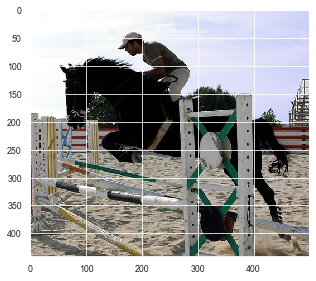

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_data)
image, labels = next(dataiter)
print(image.shape)
print(image.max())
print(image.min())
img = T.ToPILImage()(image)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img)

---
# Removing Watermark

These are the steps taken during traninig:
1. Add the watermark, on the image
    - Remeber to maintain the approximately the same size and aspect.
2. Wartermaked images are used as input and the original, clean images as targets. 


In [18]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class unWaterMarked(nn.Module):
    def __init__(self):
        super().__init__()
        # ENCODER #
        # Removing Features
        self.econv_1 = nn.Sequential(nn.Conv2d(3, 16, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(16, 16, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        self.econv_2 = nn.Sequential(nn.BatchNorm2d(16),  
                                     nn.Conv2d(16, 32, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(32, 32, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        self.econv_3 = nn.Sequential(nn.BatchNorm2d(32),
                                     nn.Conv2d(32, 64, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(64, 64, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        self.econv_4 = nn.Sequential(nn.BatchNorm2d(64),
                                     nn.Conv2d(64, 128, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(128, 128, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        self.econv_5 = nn.Sequential(nn.BatchNorm2d(128),
                                     nn.Conv2d(128, 256, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(256, 256, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        self.econv_6 = nn.Sequential(nn.BatchNorm2d(256),
                                     nn.Conv2d(256, 512, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(512, 512, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.MaxPool2d(2, 2))
        # DECODER #
        self.dconv_1 = nn.Sequential(nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.Conv2d(512, 512, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(512, 256, 3, padding=1),
                                     nn.LeakyReLU())
        self.dconv_2 = nn.Sequential(nn.BatchNorm2d(256),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.Conv2d(256, 256, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(256, 128, 3, padding=1),
                                     nn.LeakyReLU())
        self.dconv_3 = nn.Sequential(nn.BatchNorm2d(128),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.Conv2d(128, 128, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(128, 64, 3, padding=1),
                                     nn.LeakyReLU())
        self.dconv_4 = nn.Sequential(nn.BatchNorm2d(64),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.Conv2d(64, 64, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(64, 32, 3, padding=1),
                                     nn.LeakyReLU())
        self.dconv_5 = nn.Sequential(nn.BatchNorm2d(32),
                                     nn.UpsamplingNearest2d(scale_factor=2),
                                     nn.Conv2d(32, 32, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(32, 16, 3, padding=1),
                                     nn.LeakyReLU(),)
        self.dconv_6 = nn.Sequential(nn.BatchNorm2d(16),
                                     nn.Conv2d(16, 16, 3, padding=1),
                                     nn.LeakyReLU(),
                                     nn.Conv2d(16, 3, 3, padding=1),
                                     nn.LeakyReLU())
        # Definition
        self.encode = nn.Sequential(self.econv_1, self.econv_2, self.econv_3,
                                    self.econv_4, self.econv_5, self.econv_6)
        self.decode = nn.Sequential(self.dconv_1, self.dconv_2, self.dconv_3,
                                    self.dconv_4, self.dconv_5, self.dconv_6)

    def forward(self, x):
        ## encode ##
        x = self.encode(x)
        x = self.decode(x)
                
        return x

In [19]:
# initialize the NN
model = unWaterMarked()
print(model)

unWaterMarked(
  (econv_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (econv_2): Sequential(
    (0): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (econv_3): Sequential(
    (0): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): LeakyReLU(neg

---
## Training

We are only concerned with the training images, which we can get from the `train_loader`.

>In this case, we are actually **adding some noise** to these images and we'll feed these `noisy_imgs` to our model. The model will produce reconstructed images based on the noisy input. But, we want it to produce _normal_ un-noisy images, and so, when we calculate the loss, we will still compare the reconstructed outputs to the original images!

Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

In [20]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [5]:
# number of epochs to train the model
n_epochs = 20

# for adding noise to images


for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        
        ## add random noise to the input images
        noisy_imgs = images + noise_factor * torch.randn(*images.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
                
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        ## forward pass: compute predicted outputs by passing *noisy* images to the model
        outputs = model(noisy_imgs)
        # calculate the loss
        # the "target" is still the original, not-noisy images
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
            
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.977538
Epoch: 2 	Training Loss: 0.690527
Epoch: 3 	Training Loss: 0.640184
Epoch: 4 	Training Loss: 0.613912
Epoch: 5 	Training Loss: 0.595001
Epoch: 6 	Training Loss: 0.582570
Epoch: 7 	Training Loss: 0.572466
Epoch: 8 	Training Loss: 0.564127
Epoch: 9 	Training Loss: 0.556832
Epoch: 10 	Training Loss: 0.549967
Epoch: 11 	Training Loss: 0.544791
Epoch: 12 	Training Loss: 0.541313
Epoch: 13 	Training Loss: 0.537340
Epoch: 14 	Training Loss: 0.534824
Epoch: 15 	Training Loss: 0.531550
Epoch: 16 	Training Loss: 0.529537
Epoch: 17 	Training Loss: 0.527350
Epoch: 18 	Training Loss: 0.525628
Epoch: 19 	Training Loss: 0.523231
Epoch: 20 	Training Loss: 0.522199


## Checking out the results

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

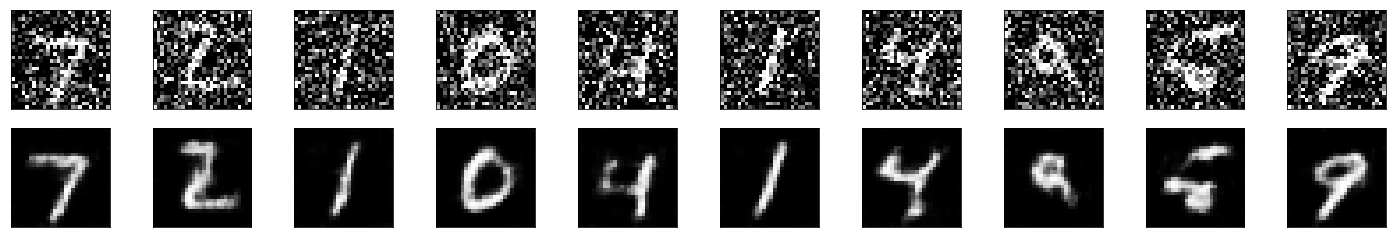

In [6]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# add noise to the test images
noisy_imgs = images + noise_factor * torch.randn(*images.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)